# Bayes Classifier and Maximum Likelihood for a multivariate Gaussian density

## Preface

Begin, if necessary, by recalling the course notes on the Bayes classifier and the principle of maximum likelihood.

In [ ]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# FOR VISUALIZATION
from ipywidgets import interact, SelectMultiple, fixed, Checkbox, IntRangeSlider, IntSlider, FloatSlider
import ipywidgets as widgets
matplotlib.rcParams['figure.figsize'] = [10,5]
plt.style.use('fivethirtyeight')

## Bayes classifier

Today we are going to build a **multi-class Bayes classifier**. This means that instead of directly modeling $ p (\mbox{class} \ | \ \mbox{example}) $ (or $ p (y \ | \ x) $), we will instead use the Bayes equation

$$ p (\mbox{class} \ | \ \mbox{example}) = \frac{p (\mbox{example} \ | \ \mbox{class})\ p (\mbox {class})} {\sum_{c'= 1}^{m} p(\mbox{example}\ | \ c')\ p(c')} $$

and model the different pieces. In fact, we just need to model the numerator since the denominator is a normalization constant.

The term $ p (\mbox{class}) $ or $p(c')$ represents the prior probability of a class, that is, our a priori belief - before we have seen any example - about the probability that an unknown example belongs to this class. We will represent this belief a priori for a class by the frequency of the latter in the training data: $ \frac{n_c}{n} $ where $ n_c $ = number of examples of the class $ c $, and $ n $ = number of training examples. Hence, $ p(\mbox{class}) = n_c / n $


We will use **multivariate Gaussian densities** to model the different $ p (\mbox{example} \ | \ \mbox{class}) $. This means that **for each class** $c$, we will assume that the "true" distribution $ p (\mbox{example} \ | \ \mbox{class}) $ has the form of a multivariate Gaussian for which we will try to learn the parameters $ \mu_c $ and $ \Sigma_c $.

## Univariate Gaussian

A **univariate** Gaussian density is a Gaussian distribution in **one** variable. Formula-wise, it is defined as ([Gaussian function](https://en.wikipedia.org/wiki/Gaussian_function)):

$$
p(x\ | \ \mu, \sigma) = \frac{1}{\sigma \sqrt{2\pi}}\exp\left(-\frac{1}{2}\frac{(x - \mu)^2}{\sigma^2}\right)
$$

i.e. a point $x$ has the above probability of belonging to that Gaussian function with $\mu$ and $\sigma$.

Code the above equation in the following function `univariate_prob`:

In [ ]:
def univariate_prob(x, mu, sigma):
  assert sigma > 0.0
  return 1/(sigma * np.sqrt(2*np.pi)) * np.exp(-1/2*(x - mu)**2/sigma**2)

Play with multiple univariate Gaussians:

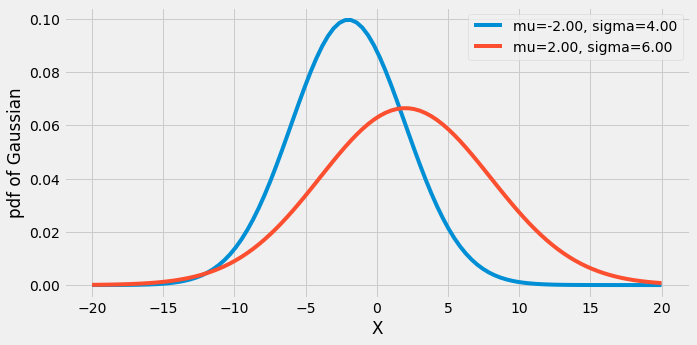

In [ ]:
def my_plot_gaussian(X, pdf, mu, sigma):
  plt.plot(X, pdf, label=f"mu={mu:.02f}, sigma={sigma:.02f}")
  plt.legend()
  plt.xlabel('X')
  plt.ylabel('pdf of Gaussian')

X = np.linspace(-20, 20, 100)

mu1, sigma1 = -2, 4
pdf1 = [univariate_prob(x, mu1, sigma1) for x in X]
my_plot_gaussian(X, pdf1, mu1, sigma1)

mu2, sigma2 = 2, 6
pdf2 = [univariate_prob(x, mu2, sigma2) for x in X]
my_plot_gaussian(X, pdf2, mu2, sigma2)

In [ ]:
@interact(
    mu=FloatSlider(min=-5, max=5, value=0, description='Mean', continuous_update=False),
    sigma=FloatSlider(min=0.0001, max=5, value=1, description='Std', continuous_update=False),
)
def interactive_gaussian(mu, sigma):
  X = np.linspace(-20, 20, 200)
  pdf = [univariate_prob(x, mu, sigma) for x in X]
  my_plot_gaussian(X, pdf, mu, sigma)


interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Mean', max=5.0, min=-5.0), …

## Fitting uni-dimsensional data to uni-variate Gaussian

Suppose we are dealing with the following data:

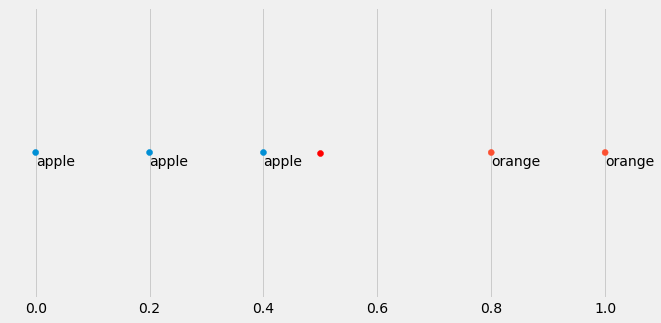

In [ ]:
pts = np.array([0.0, 0.2, 0.4, 0.8, 1.0])
classes = np.array(["apple", "apple", "apple", "orange", "orange"])
new_pt = np.array(.5)

plt.scatter(pts, np.array([0]*len(pts)), c=['C0', 'C0', 'C0', 'C1', 'C1'])
for i, (x, s) in enumerate(zip(pts, classes)):
  plt.text(x, -0.005, s)
plt.scatter([new_pt], [0], c='r')
plt.gca().axes.get_yaxis().set_visible(False)

We can choose to model the underlying distributions of each class as univariate Gaussians, with the mean and standard deviation calculated empirically from the data.

In [ ]:
pts_apple = pts[classes=="apple"]
mean_apple, std_apple = np.mean(pts_apple), np.std(pts_apple)

pts_orange = pts[classes=="orange"]
mean_orange, std_orange = np.mean(pts_orange), np.std(pts_orange)

print(f"mean_apple: {mean_apple:.02f} ; std_apple: {std_apple:.02f}")
print(f"mean_orange: {mean_orange:.02f} ; std_orange: {std_orange:.02f}")

mean_apple: 0.20 ; std_apple: 0.16
mean_orange: 0.90 ; std_orange: 0.10


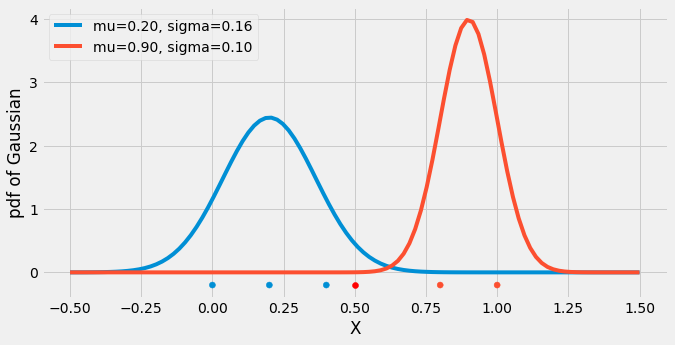

In [ ]:
X = np.linspace(-0.5, 1.5, 100)

pdf_apple = [univariate_prob(x, mean_apple, std_apple) for x in X]
my_plot_gaussian(X, pdf_apple, mean_apple, std_apple)

pdf_orange = [univariate_prob(x, mean_orange, std_orange) for x in X]
my_plot_gaussian(X, pdf_orange, mean_orange, std_orange)

plt.scatter(pts, np.array([-0.2]*len(pts)), c=['C0', 'C0', 'C0', 'C1', 'C1'])
# for i, (x, s) in enumerate(zip(pts, classes)):
#   plt.text(x, -0.5, s)
plt.scatter([new_pt], [-0.2], c='r')

We can now calculate the (approximate) probability of the red point belonging to either Gaussian, i.e. $p(\mbox{red}\ |\ \mbox{apple})$ and $p(\mbox{red}\ |\ \mbox{orange})$, and compare.

In [ ]:
p_red_given_apple = univariate_prob(new_pt, mean_apple, std_apple)
p_red_given_orange = univariate_prob(new_pt, mean_orange, std_orange)
print(f"p(red | apple): {p_red_given_apple:.04f}; p(red | orange): {p_red_given_orange:.04f}")

p(red | apple): 0.4519; p(red | orange): 0.0013


The probability of the red point being an apple or orange is given by the numerator in the Bayesian equation:

$$p(\mbox{apple}\ |\ \mbox{red}) \approx p(\mbox{red}\ |\ \mbox{apple})\ p(\mbox{apple})\\
p(\mbox{orange}\ |\ \mbox{red}) \approx p(\mbox{red}\ |\ \mbox{orange})\ p(\mbox{orange})
$$

where $p(\mbox{apple})$ and $p(\mbox{orange})$ are the a priori beliefs that the red point was an apple or an orange.

Suppose it equally probably a priori that any new point is an apple or an orange.

In [ ]:
p_apple_given_red = p_red_given_apple * 0.5
p_orange_given_red = p_red_given_orange * 0.5
print(f"p(apple | red): {p_apple_given_red:.04f}; p(orange | red): {p_orange_given_red:.04f}")

p(apple | red): 0.2260; p(orange | red): 0.0007



Since $p(\mbox{apple}\ |\ \mbox{red}) > p(\mbox{orange}\ |\ \mbox{red})$, we can conclude that the red point is **probably** an apple!

## Multi-variate Gaussian densities

For higer-dimensional data, we use multivariate Gaussians.

In [ ]:
X1 = np.linspace(-3, 3, 100)
X2 = np.linspace(-3, 3, 100)
X1, X2 = np.meshgrid(X1, X2)
X1.shape

(100, 100)

In [ ]:
def plot_2D_gaussian(mu, Sigma):
  X1 = np.linspace(-3, 3, 100)
  X2 = np.linspace(-3, 3, 100)
  X1, X2 = np.meshgrid(X1, X2)
  # Pack X and Y into a single 3-dimensional array
  pos = np.empty(X1.shape + (2,))
  pos[:, :, 0] = X1
  pos[:, :, 1] = X2

  # https://scipython.com/blog/visualizing-the-bivariate-gaussian-distribution/
  def multivariate_gaussian(pos, mu, Sigma):
      """Return the multivariate Gaussian distribution on array pos.
      pos is an array constructed by packing the meshed arrays of variables
      x_1, x_2, x_3, ..., x_k into its _last_ dimension.
      """
      n = mu.shape[0]
      Sigma_det = np.linalg.det(Sigma)
      Sigma_inv = np.linalg.inv(Sigma)
      N = np.sqrt((2*np.pi)**n * Sigma_det)
      # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
      # way across all the input variables.
      fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)
      return np.exp(-fac / 2) / N

  # The distribution on the variables X, Y packed into pos.
  pdf = multivariate_gaussian(pos, mu, Sigma)

  from matplotlib import cm
  fig = plt.figure()
  ax = fig.gca(projection='3d')
  ax.plot_surface(X1, X2, pdf, rstride=3, cstride=3, linewidth=1, antialiased=True,
                  cmap=cm.viridis)
  ax.set_xlabel('X1')
  ax.set_ylabel('X2')

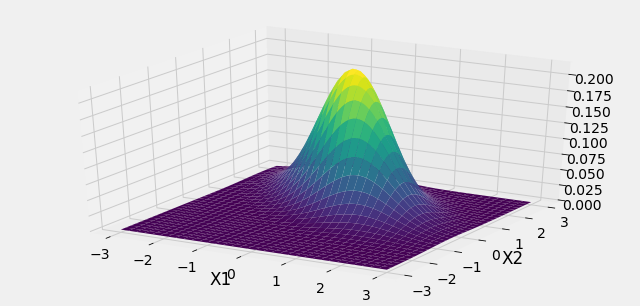

In [ ]:
mu = np.array([0., 1.])
Sigma = np.array([[ 1. , -0.5], [-0.5,  0.8]])
plot_2D_gaussian(mu, Sigma)

In [ ]:
@interact(
    mu1=FloatSlider(min=-2, max=2, value=0, description='Mean x1', continuous_update=False),
    mu2=FloatSlider(min=-2, max=2, value=0, description='Mean x2', continuous_update=False),
    s11=FloatSlider(min=0.01, max=2, value=1, description='sigma 11', continuous_update=False),
    s12=FloatSlider(min=-2, max=2, value=0, description='sigma 12', continuous_update=False),
    s21=FloatSlider(min=-2, max=2, value=0, description='sigma 21', continuous_update=False),
    s22=FloatSlider(min=0.01, max=2, value=1, description='sigma 22', continuous_update=False),
)
def interactive_2D_gaussian(mu1, mu2, s11, s12, s21, s22):
    Sigma = np.array([[s11 , s12], [s21,  s22]])
    plot_2D_gaussian(np.array([mu1, mu2]), Sigma)

interactive(children=(FloatSlider(value=0.0, continuous_update=False, description='Mean x1', max=2.0, min=-2.0…

In practice, we will limit ourselves today to a particular case of this distribution: the **isotropic Guassian**, i.e. the covariance matrix $ \Sigma_c $ of each Gaussian is diagonal and that each element of this diagonal is the same (we denote it as $ \sigma^2 $). Thus we have a single parameter to control the expression of the covariance for each class. It's easier (for us and for the computer) to calculate, but it also means that our model is less powerful.

## Fitting data to Multi-variate Gaussians

Hence, we have a very simple parametric model for each class $c$. The parameters are the average $ \mu_c $ (a vector of the same dimension as the dimension of the system input) and the variance $ \sigma^2_c $ (a single scalar in our simple model, which will multiply the identity matrix). We are going to learn this model with the **maximum likelihood principle**. For each class, we will find the values of the parameters that maximize the log-likelihood of the training data from this class.

For an isotropic Gaussian of dimension $d$, the maximum likelihood estimators of $\mu$ and $\sigma^2$ are given by the empirical mean and variance: 

$$\mu_{ML} = \frac{1}{n} \sum_{i=1}^{n} x_i$$

$$\sigma_{ML}^2 = \frac{1}{nd} \sum_{i=1}^{n} (x_i-\mu_{ML})^T(x_i-\mu_{ML})$$

Having found the parameters that maximize the likelihood for each class, we can calculate each $ p (\mbox{example} \ |  \ \mbox{class}) $. It is now sufficient to apply the Bayes rule in order to classify a new example. More precisely, we want to choose, for an example, the class that maximizes $ p(\mbox{example} \ | \ \mbox{class}) p(\mbox{class}) $ or, equivalently, $ \log (p (\mbox{example } \ | \ \mbox{class} ) p(\mbox{class})) $. **At test time, our classifier needs to evaluate this quantity for each class, and use the obtained values to assign a class label**.

$$ \log p(\mathbf{x}) = \log p(x_1, x_2, \dots) = \log \prod_d p(x_i) = \sum_d \log p(x_i) $$

## Code to be completed

For the `GaussianMaxLikelihood` class:
 
  - **Calculate** mu ($\mu$) and sigma_sq ($ \sigma^2 $), the mean and the variance in `GaussianMaxLikelihood.train`. 
  - **Calculate** the value of the Gaussian density function in `GaussianMaxLikelihood.loglikelihood`, store it in the variable `log_prob` and **return it**.
  
In `__init__`, we initialize `self.mu` and `self.sigma_sq`. But both variables will be updated when the `train` function is called.

In [ ]:
class GaussianMaxLikelihood:
    def __init__(self, n_dims):
        self.n_dims = n_dims
        self.mu = np.zeros(n_dims)
        # We only save a scalar standard deviation because our model is the isotropic Gaussian
        self.sigma_sq = 1.0

    # For a training set, the function should compute the ML estimator of the mean and the variance
    def train(self, train_data):
        # Here, you have to find the mean and variance of the train_data data and put it in self.mu and self.sigma_sq
        self.mu = np.mean(train_data, axis=0)
        self.sigma_sq = np.sum((train_data - self.mu) ** 2.0) / (self.n_dims * train_data.shape[0]) 
        
    # Returns a vector of size nb. of test ex. containing the log probabilities of each test example under the model.
    # exemple test
    def loglikelihood(self, test_data):
        # # the following line calculates log(normalization constant) i.e. log( 1/(sigma sqrt(2pi)) )
        # c = self.n_dims * -(np.log(np.sqrt(self.sigma_sq)) + (1 / 2) * np.log(2 * np.pi))
        # log_prob = c - np.sum((test_data - self.mu) ** 2.0, axis=1) / (2.0 * self.sigma_sq)
        # OR
        log_prob = np.sum(-(np.log(np.sqrt(self.sigma_sq)) + (1 / 2) * np.log(2 * np.pi)) - (test_data - self.mu) ** 2/ (2 * self.sigma_sq), axis=1)
        return log_prob

For class `BayesClassifier`:

  - **Complete** `bayes_classifier.loglikelihood`
  
`self.maximum_likelihood_models` is a list of models per class that allows log likelihood evaluations using a `loglikelihood` method. It is of size equal to the number of classes.

`self.priors` is a list of scalars representing the prior probabilities of the classes, in the same order of classes as `self.maximum_likelihood_models`.


In [ ]:
class BayesClassifier:
    def __init__(self, maximum_likelihood_models, priors):
        self.maximum_likelihood_models = maximum_likelihood_models
        self.priors = priors
        if len(self.maximum_likelihood_models) != len(self.priors):
            print('The number of ML models must be equal to the number of priors!')
        self.n_classes = len(self.maximum_likelihood_models)

    # Returns a matrix of size number of test ex. times number of classes containing the log
    # probabilities of each test example under each model, trained by ML.
    def loglikelihood(self, test_data):

        log_pred = np.zeros((test_data.shape[0], self.n_classes))

        for i in range(self.n_classes):
            # Here, we will have to use maximum_likelihood_models[i] and priors to fill in
            # each column of log_pred (it's more efficient to do a entire column at a time)
            log_pred[:, i] = self.maximum_likelihood_models[i].loglikelihood(test_data) + np.log(self.priors[i])

        return log_pred

## Train

In this part, we will train a BayesClassifier on the iris dataset, according to the what we described in the High level description section. We will use the classes BayesClassifier and GaussianMaxLikelihood.

There are extra questions at the end of this notebook where you can play around.

**Complete** the function `get_accuracy(test_inputs, test_labels)`, that takes as input a test set, and returns the trained classifier's (`classifier`) accuracy on this test set. Your function should return a number between 0 and 1.

To make sure everything works fine, you can test your code by calling your function on the train dataset (This part of the code after the function is provided for you).


In [ ]:
# We load the dataset
import sys
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
    iris = np.loadtxt('http://www.iro.umontreal.ca/~dift3395/files/iris.txt')
else:
    iris = np.loadtxt('iris.txt')

# We split the dataset into input data, and labels
iris_data = iris[:, :-1]
iris_labels = iris[:, -1]

# Seed the randomizer
import random
random.seed(3395)
# Randomly choose indexes for the train and val dataset, say with 80-20 split
num_data = iris_data.shape[0]
inds = list(range(num_data))
random.shuffle(inds)
train_inds = inds[:int(0.8*num_data)]
val_inds = inds[int(0.8*num_data):]

# Split the data into train and val sets
train_data = iris_data[train_inds, :]
train_labels = iris_labels[train_inds]
val_data = iris_data[val_inds, :]
val_labels = iris_labels[val_inds]

In [ ]:
# We split the input data into three sub-datasets, corresponding to the classes 1, 2, and 3. 
# It is necessary to make such a split, in order to train a GaussianMaxLikelihood model per class.
iris_train1 = train_data[train_labels==1, :]
iris_train2 = train_data[train_labels==2, :]
iris_train3 = train_data[train_labels==3, :]

In [ ]:
# We create a model per class (using maximum likelihood)
model_class1 = GaussianMaxLikelihood(4)
model_class2 = GaussianMaxLikelihood(4)
model_class3 = GaussianMaxLikelihood(4)

# We train each of them using the corresponding data
model_class1.train(iris_train1)
model_class2.train(iris_train2)
model_class3.train(iris_train3)

In [ ]:
# We create a list of all our models, and the list of prior values
# Here the priors are calculated exactly because we know the number of representatives per class.
model_ml = [model_class1, model_class2, model_class3]
total_num = len(iris_train1) + len(iris_train2) + len(iris_train3)
priors = [len(iris_train1)/(total_num), len(iris_train2)/(total_num), len(iris_train3)/(total_num)]

In [ ]:
# We create our classifier with our list of Gaussian models and our priors
classifier = BayesClassifier(model_ml, priors)

In [ ]:
# Returns a number between 0 and 1 representing the accuracy of the model on the test_inputs
def get_accuracy(data, labels):
    # Calculate the log-probabilities according to our model
    log_prob = classifier.loglikelihood(data)
    # Predict labels
    classes_pred = log_prob.argmax(1) + 1
    # Calculate the accuracy by comparing the predicted labels with the actual labels
    acc = np.mean(classes_pred == labels)
    return acc

In [ ]:
print("The training accuracy is : {:.2f} % ".format(100 * get_accuracy(train_data, train_labels)))
print("The validation accuracy is : {:.2f} % ".format(100 * get_accuracy(val_data, val_labels)))

The training accuracy is : 90.83 % 
The validation accuracy is : 100.00 % 


## Bonus questions

- Change your code so that `GaussianMaxLikelihood` calculates 1) a diagonal covariance matrix (where we estimate the variance for each component / trait of the input) 2) a full covariance matrix. You can for example have a parameter `cov_type` that can be "isotropic", "diagonal" or "full". The `numpy.cov` and` numpy.var` commands will probably be useful.

- Instead of using the whole iris dataset to train a `BayesClassifier`, peform a random split of the data (2/3, 1/3) to obtain a train set and a test set, and use the train set to train your classifier. Compare the obtained accuracies on the train set and the test set. Remember to adjust the code that defines `iris_train1`, `iris_train2`, `iris_train3`, and `priors` accordingly. Compare the train and test accuracies of 3 models: one that uses "isotropic" gaussian models, one that uses "diagonal" gaussian models, and one that uses "full" gaussian models.

- Instead of using the 4 features to train the classifier, use only 2 and try to make nice visualizations as we did in Lab 2. You can of course use the utility functions from there to make your plots.